In [1]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import train_test_split

from planet.app import Planet

In [2]:
archive = Path('export.csv')
index = np.arange(0, 160178, 1)  # количество индексов = количеству строк в файле

quacke_df = pd.read_csv(archive, index_col=False, encoding='windows-1251', sep=';')

non_data = ['Дата', 'Час', 'Мин', 'Сек', 'Ошибка по времени', 'Ошибка по широте', 'Ошибка по долготе', 'Ошибка по глубине', 'Глубина', 'Код сети', 'Сейсмический регион', 'Географический регион', 'Макросейсмические данные']

/tmp/ipykernel_493558/3769868989.py:4: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  quacke_df = pd.read_csv(archive, index_col=False, encoding='windows-1251', sep=';')


In [3]:
def add_param(frame):
    frame['Долгота'] = float(frame['Долгота'].replace(',', '.'))  # Долгота
    frame['Широта'] = float(frame['Широта'].replace(',', '.'))  # Широта
    date = frame['Дата']
    frame['Магнитуда'] = float(frame['Магнитуда'].replace(',', '.')) 

    planet = Planet(frame['Долгота'], frame['Широта'], date)

    return pd.concat([frame, pd.Series(planet.get_parametrs())])

In [4]:
quacke_df = quacke_df.apply(add_param, axis=1)

quacke_df = quacke_df.drop(non_data, axis=1)
quacke_df = quacke_df.dropna()

quacke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160178 entries, 0 to 160177
Data columns (total 51 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Широта                  160178 non-null  float64
 1   Долгота                 160178 non-null  float64
 2   Магнитуда               160178 non-null  float64
 3   Mercury_earth_distance  160178 non-null  float64
 4   Mercury_sun_distance    160178 non-null  float64
 5   Mercury_hlat            160178 non-null  float64
 6   Mercury_hlon            160178 non-null  float64
 7   Mercury_size            160178 non-null  float64
 8   Mercury_radius          160178 non-null  float64
 9   Mercury_a_ra            160178 non-null  float64
 10  Mercury_elong           160178 non-null  float64
 11  Venus_earth_distance    160178 non-null  float64
 12  Venus_sun_distance      160178 non-null  float64
 13  Venus_hlat              160178 non-null  float64
 14  Venus_hlon          

In [5]:
target_column = 'Магнитуда'
y = quacke_df[target_column]
X = quacke_df.drop(target_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
ridge_model = RidgeCV(alphas=(0.1, 1, 10), cv=20)
ridge_model.fit(X_train, y_train)

lasso_model = LassoCV(cv=20)
lasso_model.fit(X_train, y_train)

LassoCV(cv=20)

In [7]:
y_pred = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)

x = np.arange(1, len(y_test)+1,1)[:100]
pic_y_lasso = pd.Series(y_pred_lasso[:100]).set_axis(x)
pic_y_test = y_test[:100].set_axis(x)
pic_y_ridge = pd.Series(y_pred[:100]).set_axis(x)

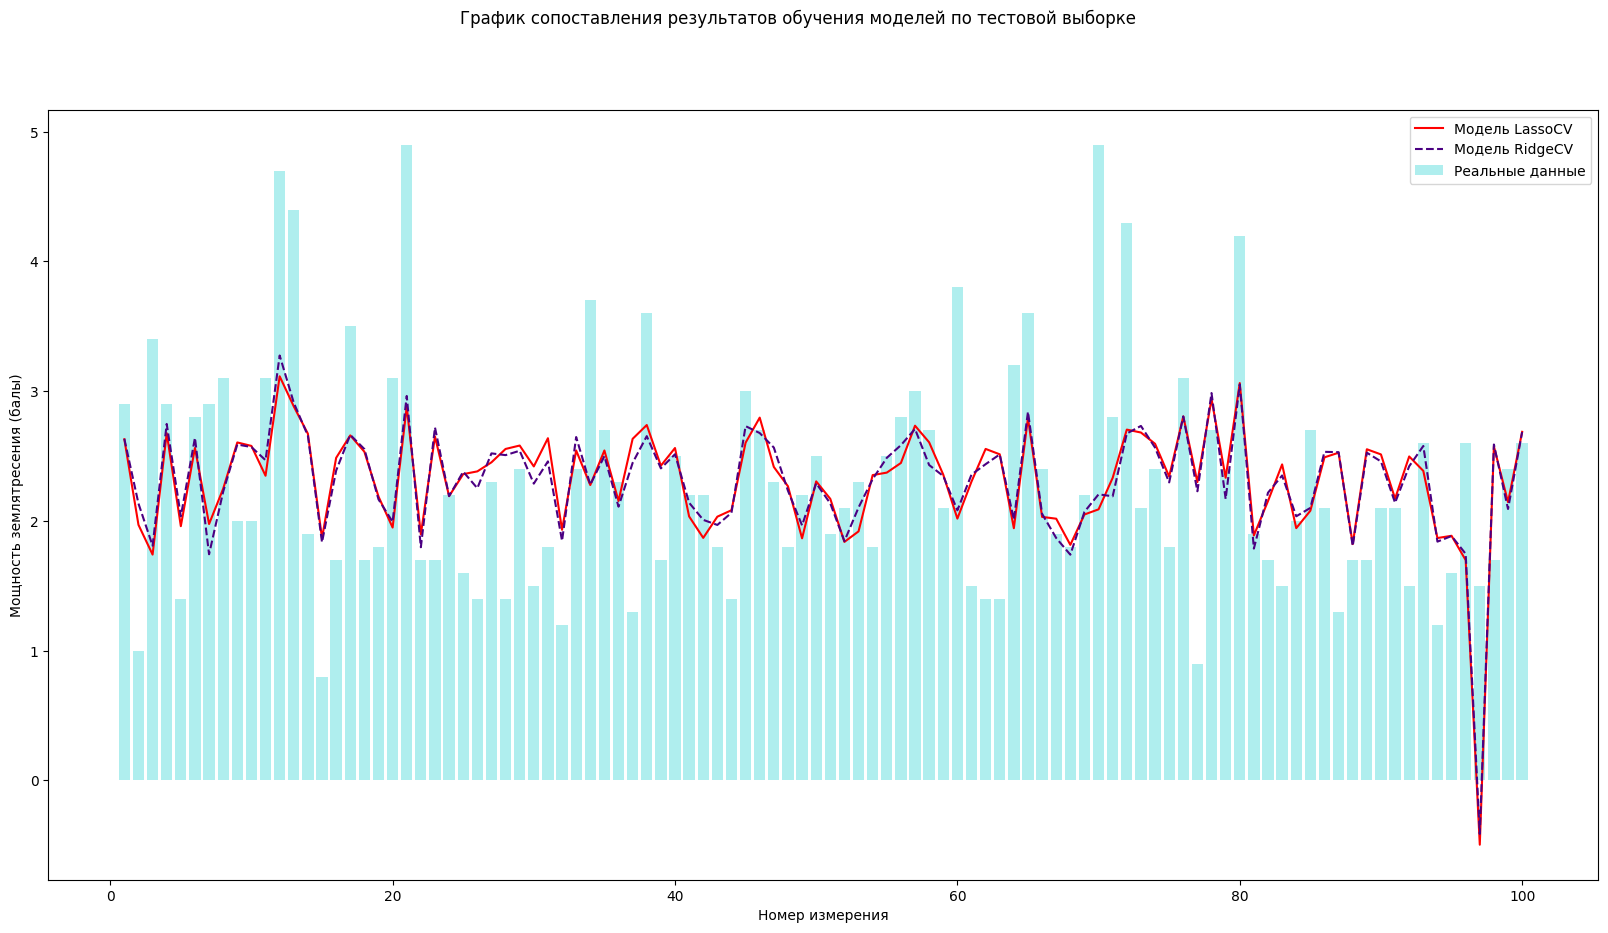

In [10]:
plt.figure(figsize=(20,10))
plt.suptitle('График сопоставления результатов обучения моделей по тестовой выборке')

plt.bar(x, pic_y_test,label='Реальные данные', color='#AFEEEE')
plt.plot(pic_y_lasso, '-r', label='Модель LassoCV')
plt.plot(pic_y_ridge, '--', color='#4B0082', label='Модель RidgeCV')
plt.xlabel('Номер измерения')
plt.ylabel('Мощность землятресения (балы)')
plt.legend(loc='best')

plt.show()

In [9]:
joblib.dump(ridge_model, 'filename.pkl') 

['filename.pkl']